In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print("complete")

/kaggle/input/natural-language-processing-with-disaster-tweets/kaggle nlp/sample_submission.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/kaggle nlp/Natural Language Processing with Disaster Tweets (1).ipynb
/kaggle/input/natural-language-processing-with-disaster-tweets/kaggle nlp/train.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/kaggle nlp/test.csv
complete


In [2]:
import spacy
import re
import string
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import nltk
def getSentences(text):
    nlp = English()
    #nlp.add_pipe(nlp.create_pipe('sentencizer'))
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    print(document)
    #return [sent.string.strip() for sent in document.sents]
    return [sent.text.strip() for sent in document.sents]


def printToken(token):
    print(token.text, "->", token.dep_)
    
def appendChunk(original, chunk):
    return original + ' ' + chunk
def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)
def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
            
    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())


def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)
print("complete")

complete


In [3]:
df_train = pd.read_csv('../input/natural-language-processing-with-disaster-tweets/kaggle nlp/train.csv', dtype={'id': np.int16, 'target': np.int8},nrows=100)
df_test = pd.read_csv('../input/natural-language-processing-with-disaster-tweets/kaggle nlp/test.csv', dtype={'id': np.int16},nrows=100)
print("complete")

complete


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G,k=2, iterations=50)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=5000, node_color='lightblue', alpha=0.9,font_size=10,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()
print("complete")

complete


In [6]:
def clean_text(x):
    text = re.sub('(\d+)','',x)   
    text = text.lower()
    return text
def remove_url(x):
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})\/([a-zA-Z0-9_]+]*)',' ',x)
    return text
def remove_punct(x):
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].apply(remove_url)
df_train['text'] = df_train['text'].apply(remove_punct)
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print("complete")

complete


In [7]:
text = df_train['text'].tolist()
read_1 = text[:10]
read_1

print("complete")

complete


In [8]:
if __name__ == "__main__":
    
    text = 'deeds reason earthquake may allah forgive us'

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

print("complete")

deeds reason earthquake may allah forgive us
deeds reason earthquake may allah forgive us
deeds -> nsubj
reason -> compound
earthquake -> dobj
may -> aux
allah -> nsubj
forgive -> ROOT
us -> dobj
deeds allah , forgive , earthquake us
complete


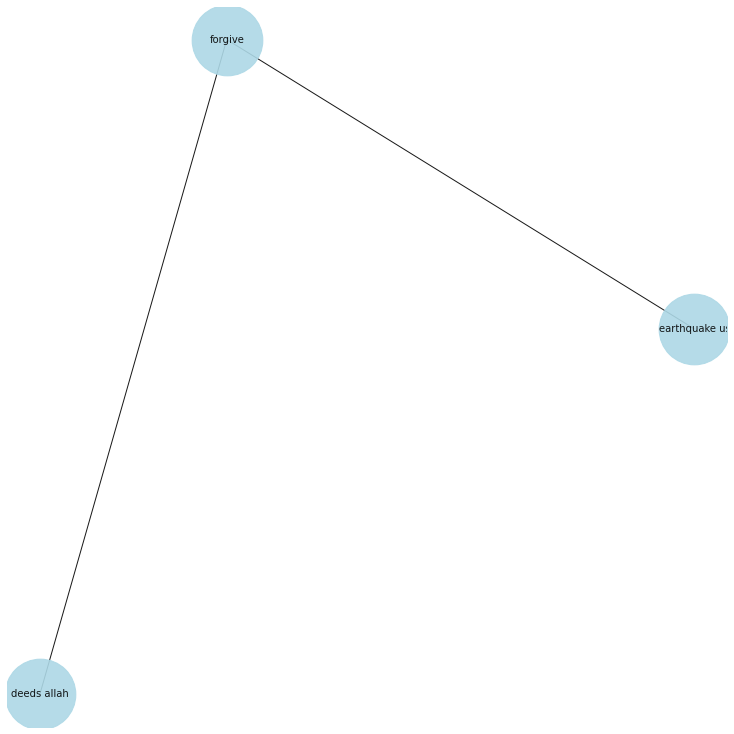

complete


In [9]:
printGraph(triples)

print("complete")